Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [15]:
import pandas as pd
dataurl = 'https://raw.githubusercontent.com/Nckflannery/Unit2-Project/master/Data/NFL%20Combine%20Data%20-%20Combine%20Results.csv'
colnames = ['Year', 'Name', 'YearName', 'College', 'POS', 'Height',
       'Weight', 'Hand Size', 'Arm Length', 'Wonderlic',
       '40 Yard', 'Bench Press', 'Vert Leap', 'Broad Jump',
       'Shuttle', '3Cone', '60Yd Shuttle', 'Pick', 'Round']
df=pd.read_csv(dataurl, names=colnames, skiprows=1)

In [16]:
df.head()

,Year,Name,YearName,College,POS,Height,Weight,Hand Size,Arm Length,Wonderlic,40 Yard,Bench Press,Vert Leap,Broad Jump,Shuttle,3Cone,60Yd Shuttle,Pick,Round
0,2015,Ameer Abdullah,2015Ameer Abdullah,Nebraska,RB,68.75,205,8.63,30.00,NaN,4.60,24.0,42.5,130.0,3.95,6.79,11.18,54.0,2.0
1,2015,Nelson Agholor,2015Nelson Agholor,Southern California,WR,72.13,198,9.25,32.25,NaN,4.42,12.0,NaN,NaN,NaN,NaN,NaN,20.0,1.0
2,2015,Malcolm Agnew,2015Malcolm Agnew,Southern Illinois,RB,70.00,202,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,Jay Ajayi,2015Jay Ajayi,Boise State,RB,71.75,221,10.00,32.00,24.0,4.57,19.0,39.0,121.0,4.10,7.10,11.10,149.0,5.0
4,2015,Brandon Alexander,2015Brandon Alexander,Central Florida,FS,74.00,195,NaN,NaN,NaN,4.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
x = df.copy()

In [63]:
x.isnull().sum()

Year               0
Name               0
YearName           0
College            0
POS                0
Height             0
Weight             0
Hand Size       1518
Arm Length      1836
Wonderlic       8960
40 Yard          750
Bench Press     3006
Vert Leap       1784
Broad Jump      1920
Shuttle         2598
3Cone           5186
60Yd Shuttle    6263
Pick            3599
Round           3599
dtype: int64

# Let's look at different ways of handling the NaN values. First, let's just set them all to 0

In [433]:
x = x.fillna(0)

In [434]:
x.isnull().sum()

Year            0
Name            0
YearName        0
College         0
POS             0
Height          0
Weight          0
Hand Size       0
Arm Length      0
Wonderlic       0
40 Yard         0
Bench Press     0
Vert Leap       0
Broad Jump      0
Shuttle         0
3Cone           0
60Yd Shuttle    0
Pick            0
Round           0
dtype: int64

In [435]:
# Get baseline prediction for round drafted
x['Round'].value_counts(normalize=True)

0.0     0.386491
3.0     0.087521
2.0     0.086018
4.0     0.085696
1.0     0.081830
5.0     0.080326
6.0     0.072487
7.0     0.072165
8.0     0.012994
9.0     0.009343
10.0    0.009128
11.0    0.008269
12.0    0.007732
Name: Round, dtype: float64

In [436]:
# Baseline prediction will be 38.65% accurate

In [469]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import category_encoders as ce
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor, XGBRegressor, XGBClassifier, XGBRFClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

target = 'Round'
drop = ['Year', 'Name', 'YearName', 'Pick', 'Round']

train, test = train_test_split(x, random_state=42, test_size=.2)
train.shape, test.shape

((7449, 19), (1863, 19))

In [438]:
X_train = train.drop(drop, axis=1)
X_test = test.drop(drop, axis=1)
y_train = train[target]
y_test = test[target]

In [439]:
X_train.columns

Index(['College', 'POS', 'Height', 'Weight', 'Hand Size', 'Arm Length',
       'Wonderlic', '40 Yard', 'Bench Press', 'Vert Leap', 'Broad Jump',
       'Shuttle', '3Cone', '60Yd Shuttle'],
      dtype='object')

In [440]:
forest_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestRegressor(n_jobs=-1, n_estimators=300, random_state=42)
)
forest_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['College', 'POS'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'College',
                                          'data_type': dtype('O'),
                                          'mapping': Auburn                    1
California                2
Arizona State             3
Illinois                  4
Oregon                    5
                       ... 
West Liberty (WV)       365
Adams State (CO)        366
Langston (OK)           367
Pittsburg State (KS)    368
NaN                      -2
Length: 369, dty...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                          

In [446]:
y_pred = forest_pipeline.predict(X_test)
print(f'Test Score: {forest_pipeline.score(X_test, y_test)*100:.02f}%')
print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')

Test Score: 2.64%
Mean Absolute Error: 2.410221864376454


Very bad scores, I think this is because being drafted in the '0' round would be the best possible outcome with regression.let's try replacing our NaN's a little differently

# Different replacement strategy

In [425]:
x1 = df.copy()

In [426]:
# Let's try setting the nan's in the target to something above the max, and impute the rest of the nan's
x1['Round'].max()

12.0

In [427]:
x1['Round'] = x1['Round'].fillna(13)

In [428]:
x1['Round'].value_counts(normalize=True)

13.0    0.386491
3.0     0.087521
2.0     0.086018
4.0     0.085696
1.0     0.081830
5.0     0.080326
6.0     0.072487
7.0     0.072165
8.0     0.012994
9.0     0.009343
10.0    0.009128
11.0    0.008269
12.0    0.007732
Name: Round, dtype: float64

In [429]:
train, test = train_test_split(x1, random_state=42, test_size=.2)
train.shape, test.shape

((7449, 19), (1863, 19))

In [430]:
X_train = train.drop(drop, axis=1)
X_test = test.drop(drop, axis=1)
y_train = train[target]
y_test = test[target]

In [431]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestRegressor(n_jobs=-1, n_estimators=300, random_state=42)
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['College', 'POS'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'College',
                                          'data_type': dtype('O'),
                                          'mapping': Auburn                    1
California                2
Arizona State             3
Illinois                  4
Oregon                    5
                       ... 
West Liberty (WV)       365
Adams State (CO)        366
Langston (OK)           367
Pittsburg State (KS)    368
NaN                      -2
Length: 369, dty...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                          

In [432]:
y_pred = pipeline.predict(X_test)
print(f'Test Score: {pipeline.score(X_test, y_test)*100:.02f}%')
print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')

Test Score: 21.76%
Mean Absolute Error: 3.538098049740562


Still not very good, we will have to handle NaN's better

# Handle NaN's on a feature by feature basis

In [581]:
x2 = df.copy()

In [582]:
x2 = x2.fillna({'Hand Size':0, 'Arm Length':0, 'Wonderlic':0, '40 Yard':8, 'Bench Press':0, 'Vert Leap':0, 'Broad Jump':0, 'Shuttle':0, '3Cone':11, '60Yd Shuttle':15, 'Round':12})

In [583]:
train, test = train_test_split(x2, random_state=42, test_size=.2)
train.shape, test.shape

((7449, 19), (1863, 19))

In [584]:
X_train = train.drop(drop, axis=1)
X_test = test.drop(drop, axis=1)
y_train = train[target]
y_test = test[target]

In [534]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    RandomForestRegressor(n_jobs=-1, n_estimators=1000, random_state=42)
)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['College', 'POS'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'College',
                                          'data_type': dtype('O'),
                                          'mapping': Auburn                    1
California                2
Arizona State             3
Illinois                  4
Oregon                    5
                       ... 
West Liberty (WV)       365
Adams State (CO)        366
Langston (OK)           367
Pittsburg State (KS)    368
NaN                      -2
Length: 369, dty...
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                          

In [535]:
y_pred = pipeline.predict(X_test)
print(f'Test Score: {pipeline.score(X_test, y_test)*100:.02f}%')
print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')

Test Score: 23.88%
Mean Absolute Error: 3.1457809983896943


In [585]:
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='constant'),
    StandardScaler(),
    XGBRegressor(n_jobs=-1, n_estimators=300, random_state=42, objective='reg:squarederror')
)
pipe.fit(X_train, y_train)

C:\Users\Nick\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Nick\Anaconda3\envs\unit2\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['College', 'POS'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'College',
                                          'data_type': dtype('O'),
                                          'mapping': Auburn                    1
California                2
Arizona State             3
Illinois                  4
Oregon                    5
                       ... 
West Liberty (WV)       365
Adams State (CO)        366
Langston (OK)           367
Pittsburg State (KS)    368
NaN                      -2
Length: 369, dty...
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_we

In [586]:
y_pred = pipe.predict(X_test)
print(f'Test Score: {pipe.score(X_test, y_test)*100:.02f}%')
print(f'Mean Absolute Error: {mean_absolute_error(y_pred, y_test)}')

Test Score: 25.12%
Mean Absolute Error: 3.100435750639957


Still not great! We'll delve deeper into this in the actual project! Also, maybe this will be better handled as a Classification problem???

# Permutation importance

In [616]:
# We did a lot above, let's start fresh with our original df
df1 = df.copy()

In [617]:
df1 = df1.fillna({'Round':12})

In [618]:
train, test = train_test_split(df1, random_state=42, test_size=.2)
train.shape, test.shape

((7449, 19), (1863, 19))

In [619]:
X_train = train.drop(drop, axis=1)
X_test = test.drop(drop, axis=1)
y_train = train[target]
y_test = test[target]

In [623]:
transformer = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)
X_train_transform = transformer.fit_transform(X_train)
X_test_transform = transformer.transform(X_test)

In [624]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=500, random_state=42)
model.fit(X_train_transform, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [625]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=42
)

permuter.fit(X_test_transform, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=500,
                                                      n_jobs=-1,
                                                      oob_score=False,
   

In [627]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

40 Yard         0.371440
Weight          0.217129
Arm Length      0.142840
Bench Press     0.124208
Vert Leap       0.119655
Height          0.111903
Broad Jump      0.088761
Hand Size       0.084779
Shuttle         0.074149
College         0.052233
60Yd Shuttle    0.036783
3Cone           0.028396
POS             0.025949
Wonderlic       0.016903
dtype: float64

In [628]:
eli5.show_weights(
    permuter,
    top=None, #show permutation importances for top n features, none=all
    feature_names=feature_names,
)

Weight,Feature
0.3714 ± 0.0410,40 Yard
0.2171 ± 0.0506,Weight
0.1428 ± 0.0360,Arm Length
0.1242 ± 0.0449,Bench Press
0.1197 ± 0.0056,Vert Leap
0.1119 ± 0.0301,Height
0.0888 ± 0.0174,Broad Jump
0.0848 ± 0.0130,Hand Size
0.0741 ± 0.0085,Shuttle
0.0522 ± 0.0127,College


In [648]:
dir(eli5)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_decision_path',
 '_feature_importances',
 '_feature_names',
 '_feature_weights',
 '_graphviz',
 'absolute_import',
 'base',
 'base_utils',
 'explain',
 'explain_prediction',
 'explain_prediction_df',
 'explain_prediction_dfs',
 'explain_prediction_sklearn',
 'explain_prediction_xgboost',
 'explain_weights',
 'explain_weights_df',
 'explain_weights_dfs',
 'explain_weights_sklearn',
 'explain_weights_xgboost',
 'format_as_dataframe',
 'format_as_dataframes',
 'format_as_dict',
 'format_as_html',
 'format_as_image',
 'format_as_text',
 'format_html_styles',
 'formatters',
 'ipython',
 'permutation_importance',
 'show_prediction',
 'show_weights',
 'sklearn',
 'transform',
 'transform_feature_names',
 'utils',
 'xgboost']

In [715]:
eli5.explain_weights_df(permuter, top=None, feature_names=feature_names)

,feature,weight,std
0,40 Yard,0.371440,0.020523
1,Weight,0.217129,0.025281
2,Arm Length,0.142840,0.018022
3,Bench Press,0.124208,0.022437
4,Vert Leap,0.119655,0.002784
5,Height,0.111903,0.015042
6,Broad Jump,0.088761,0.008694
7,Hand Size,0.084779,0.006502
8,Shuttle,0.074149,0.004267
9,College,0.052233,0.006371


In [673]:
plotter = eli5.explain_weights_df(permuter, top=None, feature_names=feature_names)

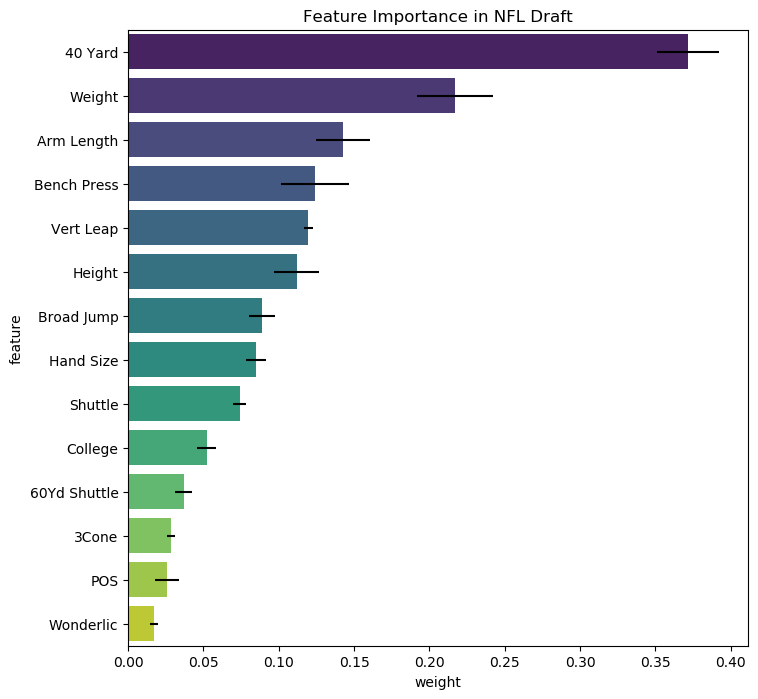

In [773]:
import seaborn as sns
import matplotlib.pyplot as plt

with plt.style.context('default'):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.barplot(data=plotter, y='feature', x='weight', palette='viridis', xerr=plotter['std'])
    ax.set_title('Feature Importance in NFL Draft')